In [1]:
!pwd

/panda/eedy/jinsha/ful-con-single-point_notebook


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from tqdm import tqdm

In [3]:
##初始SLC的路径
SLC_dir = '../../s1_a026/merged/SLC/'

##所有时间dates
dates = []         
for folder_name in os.listdir(SLC_dir):
    folder_path = os.path.join(SLC_dir, folder_name)
    if os.path.isdir(folder_path):
        try:
            date = folder_name.strip()[:8]  # 提取前8个字符作为日期（YYYYMMDD）
            dates.append(date)
        except IndexError:
            pass
dates = sorted(dates)

## int_file---生成干涉图的文件位置  ##############用了a026_1.py文件在screen下跑~~~~~~~~~~~~
interferograms_dir = './interferograms/'
all_pairs = []  ##干涉时间，例如20210202_20220202
for i in range(len(dates)):
    for j in range(i + 1, len(dates)):
        pair = f"{dates[i]}_{dates[j]}"
        all_pairs.append(pair)

cor_file = []   ##干涉图，例如./s1_a026/interferograms/20141019_20230517/20141019_20230517.int
for all_pair in all_pairs:
    file_path = os.path.join(interferograms_dir, all_pair, f'{all_pair}_filt.cor')
    cor_file.append(file_path)


igram_mean = []
# 使用tqdm添加进度条
for file_name in tqdm(cor_file, desc='Calculating mean'):
    ds = gdal.Open(file_name, gdal.GA_ReadOnly)
    igram = ds.GetRasterBand(1).ReadAsArray()
    igram_mean.append(np.mean(igram))

Calculating mean: 100%|█████████████████████████████████████████████████████████| 26335/26335 [2:52:41<00:00,  2.54it/s]


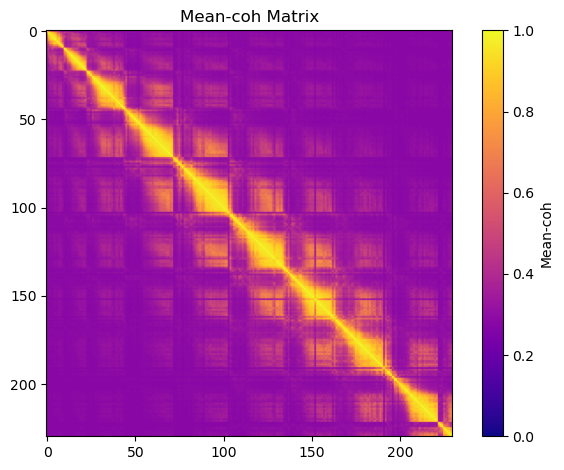

In [63]:
%matplotlib inline
# 创建时间与干涉图均值之间的映射关系
time_map = {}
for i, pair in enumerate(all_pairs):
    time_map[pair] = igram_mean[i]

# 创建时间和对应的索引映射关系
time_index_map = {date: i for i, date in enumerate(dates)}

# 创建矩阵图数据
matrix_data = np.zeros((len(dates), len(dates)))
for pair in all_pairs:
    date1, date2 = pair.split('_')
    index1 = time_index_map[date1]
    index2 = time_index_map[date2]
    matrix_data[index1][index2] = time_map[pair]

# 上下对称处理
matrix_data = np.triu(matrix_data) + np.triu(matrix_data, 1).T

# 设置对角线的值为1
np.fill_diagonal(matrix_data, 1)

# 绘制矩阵图
plt.imshow(matrix_data, cmap='plasma',vmin=0,vmax=1)
plt.colorbar(label='Mean-coh')
plt.title('Mean-coh Matrix')
plt.tight_layout()
plt.savefig('Mean-coh_Matrix.png',dpi=600)
plt.show()

In [65]:
import h5py

# 创建.h5文件
h5_file = h5py.File('a026_1_igram_mean.h5', 'w')

# 将数据写入.h5文件
h5_file.create_dataset('igram_mean', data=igram_mean)

# 关闭.h5文件
h5_file.close()